In [8]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from Network_models import HD_cell, GD_cell_hexagonal, traj, circle_period
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks, peak_widths

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
Env = Environment(params={
    'scale':4,
    "dimensionality": "2D",
})

x1 = -2
x2 = 2
x_bound = np.array([x1, x2, x2, x1, x1])
y_bound = np.array([x1, x1, x2, x2, x1])


v0 = bm.pi/1000 #baseline speed
offset_len = 1/9 #v0/2
Animal_speed = 1.*v0/2 #vary this to change the speed of the animal

def generate_trajectory(Animal_speed, dur, ifplot):
    dt = 0.001 #s
    speed_mean = Animal_speed*1e3 #m/s
    rotation_velocity_std = 40*np.pi/180 #radians
    speed_std = 0. #in m/ms

    Ag = Agent(Env, params = {
        "dt": dt,
        "speed_mean":speed_mean,
        "speed_std": speed_std,
        "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
        })

    while Ag.t < dur:
        Ag.update()
        
    Position = Ag.history['pos']
    HeadDirection = Ag.history['head_direction']
    # Velocity = Ag.history['vel']

    Position = np.array(Position) - 2
        # 计算相邻点之间的差分
    diff = np.diff(Position, axis=0)
    
    # 创建一个新的速度矩阵，初始值为0
    Velocity = np.zeros_like(Position)
    
    # 将差分结果赋值给速度矩阵
    Velocity[:-1, :] = diff

    # Velocity = np.array(Velocity)
    Moving_speed = np.linalg.norm(Velocity, axis=1)
    HeadDirection = np.array(HeadDirection)
    # 将 HeadDirection 转换为复数
    complex_numbers = HeadDirection[:, 0] + 1j * HeadDirection[:, 1]
    # 计算复数的幅角
    HD_angle = np.angle(complex_numbers)

    if ifplot == True:
        #plot Position
        fig, ax = plt.subplots(1,3,figsize=(9,3))
        ax[0].plot(x_bound, y_bound, 'k')
        ax[0].plot(Position[5000:,0], Position[5000:,1])
        ax[0].axis('equal')   
        ax[0].set_title('Animal location')
        ax[1].plot(Moving_speed)
        ax[1].set_title('Moving speed')
        ax[2].plot(HD_angle)
        ax[2].set_title('Head-direction angle')
        plt.tight_layout()

    return Position, Moving_speed, HD_angle
Position, Moving_speed, HD_angle = generate_trajectory(Animal_speed, dur=10, ifplot=True)
plt.show()
print(Moving_speed.shape)
print(Position.shape)

KeyboardInterrupt: 

In [ ]:

bm.set_dt(1.)
num_hd = 100
noise_stre = 0.1
v0 = 1.0*bm.pi/1000 #baseline speed
offset_len = 1/9
Animal_speed = 1.0*v0/2 #vary this to change the speed of the animal
A = 5. #1.6
mbar_gc = 15. 
mabr_hd = 12.

alpha_hd = 0.4
alpha_gc = 0.6

Grid_net = GD_cell_hexagonal(
    A = A, # 3
    a = 0.8,
    k = 1.0,
    tau = 10.,
    tau_v = 100.,
    mbar = mbar_gc,
    noise_stre = noise_stre,
    num_hd = num_hd,
)
HD_net = HD_cell(num=num_hd, 
                noise_stre = noise_stre/10, #gc has muhc more neurons than hd, 10000 vs 100
                tau=10., tau_v=100., 
                k=1., mbar=mabr_hd, a=0.4, A=3., J0=4., 
                z_min=-bm.pi, z_max=bm.pi)

In [ ]:

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Moving_speed):  # 20 x size

    theta_modulation_stre_hd = alpha_hd * 1/v0 * Moving_speed * 2
    theta_modulation_stre_gc = alpha_gc * 1/v0 * Moving_speed

    T_theta = 100
    #calculate TheataModulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = 1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center #center of mass of internal direction
    HD_activity = HD_net.r 
    #update the grid cell network 
    Phase_Offset = offset_len
    Grid_net.step_run(i, Animal_location, HD_activity, ThetaModulator_GC, Phase_Offset, Head_direction)
    
    #get results
    GC_bumpcenter = Grid_net.center_pos
    GC_bumpactivity = Grid_net.bump
    return GC_bumpcenter, Internal_direction, GC_bumpactivity, HD_activity


# run network
numT = Moving_speed.shape[0]
time_steps = np.arange(numT)
center_grid, center_HD, r_grid, r_HD = bm.for_loop(
    run_CoupleNet, (time_steps, Position, HD_angle, Moving_speed), progress_bar=True
)


  0%|          | 0/10001 [00:00<?, ?it/s]

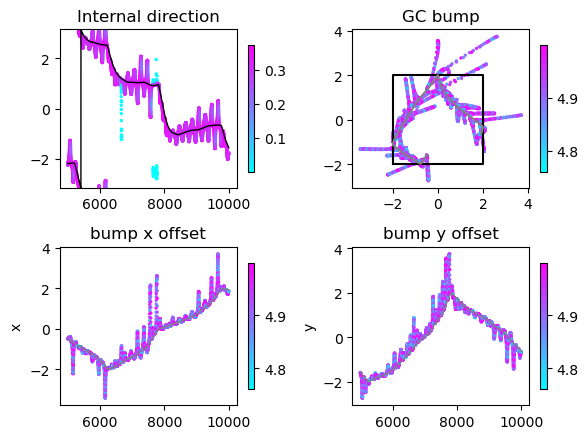

In [10]:
start=5000
max_r_grid = np.max(r_grid, axis=1)
max_bump_activity = np.max(r_HD, axis=1)
fig, axs = plt.subplots(2, 2, figsize=(6, 4.5))
s_size = 2

ax = axs[0, 0]
ax.plot(time_steps[start:], HD_angle[start:], linewidth=1, color='black')

cb = ax.scatter(time_steps[start:], 
                center_HD[start:], 
                c=max_bump_activity[start:], 
                cmap='cool', s=s_size)
ax.set_ylim(-bm.pi, bm.pi)
#colorbar
cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
ax.set_title('Internal direction')

ax = axs[0, 1]
ax.plot(x_bound, y_bound, 'k')
sc = ax.scatter(
                center_grid[start:, 0],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.plot(Position[start:, 0], Position[start:, 1], color="gray")
ax.set_title('GC bump')


ax = axs[1, 0]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], Position[start:, 0], color='grey', linewidth=1)
ax.set_ylabel("x")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 0],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump x offset')


ax = axs[1, 1]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], Position[start:, 1], color='grey', linewidth=1)
ax.set_ylabel("y")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump y offset')

plt.tight_layout()
plt.show()

MovieWriter Pillow unavailable; using Pillow instead.


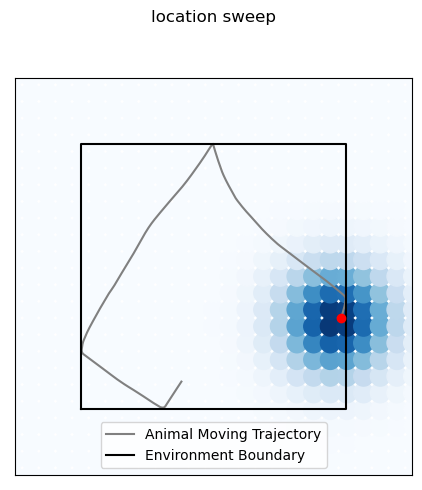

In [13]:
from matplotlib.gridspec import GridSpec

phi = Grid_net.value_bump
n_step = 10

fig = plt.figure(figsize=(10, 5), dpi=100)
gs = GridSpec(1, 1)

# 只保留第二子图使用笛卡尔坐标
ax_cartesian = fig.add_subplot(gs[0, 0])
R_g = r_grid[start:, :]
data = R_g[::n_step, :]
T = data.shape[0]
ax_cartesian.set_aspect("equal")
ax_cartesian.grid(True)

# 绘制动物运动轨迹和环境边界
ax_cartesian.plot(Position[start:, 0], Position[start:, 1], color="gray", label='Animal Moving Trajectory')
ax_cartesian.plot(x_bound, y_bound, 'k', label='Environment Boundary')
ax_cartesian.legend()
vmin1 = 0
vmax1 = np.max(data)
scatter1 = ax_cartesian.scatter([], [], c=[], s=200, cmap="Blues", vmin=vmin1, vmax=vmax1)
red_dot, = ax_cartesian.plot([], [], 'ro')  # 红点

ax_cartesian.set_title("location sweep", pad=40)
ax_cartesian.set_xlim(-3, 3)
ax_cartesian.set_ylim(-3, 3)

# 移除ticks
ax_cartesian.set_xticks([])
ax_cartesian.set_yticks([])

def update(frame):
    y1 = data[frame].flatten()
    scatter1.set_offsets(np.column_stack((phi[:, 0], phi[:, 1])))
    scatter1.set_array(y1)
    red_dot.set_data(Position[start + n_step*frame, 0], Position[start + n_step*frame, 1])  # 更新红点位置
    return scatter1, red_dot

ani = FuncAnimation(fig, update, frames=T, interval=100, blit=False)
plt.tight_layout()

aniname = "./Animation/real_trajectory.gif"
ani.save(aniname, writer="Pillow", fps=10)
